In [1]:
### BELOW IS THE CONNECTION CODE TO BASEBALL COMPUTER ###

# Duckdb is a SQL engine that allows us to execute powerful, analytics-friendly
# queries against local or remote databases and flat files.
import duckdb
import pandas as pd
import numpy as np

# Create a database file on disk
conn = duckdb.connect('example.db')
# Enable remote access
conn.sql("INSTALL httpfs")
conn.sql("LOAD httpfs")
# This database file points to files totaling multiple GBs,
# but it's only about 300KB itself. The `ATTACH` command
# gives us access to views that sit on top of remote Parquet files.
try:
  conn.sql("ATTACH 'https://data.baseball.computer/dbt/bc_remote.db' (READ_ONLY)")
except duckdb.BinderException:
  # This command will fail if you run it more than once because it already exists,
  # in which case we don't need to do anything
  pass

conn.sql("USE bc_remote")
conn.sql("USE main_models")

pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import linear_model,metrics, neural_network

In [2]:
date = '2018-01-01'

In [3]:
def grab_writeHistory(date):
        ### GRAB ALL BATTING STATS FROM BASEBALL COMPUTER ###
        query = """ 
                SELECT a.*, b.date
                FROM main_models.event_batting_stats as a
                LEFT JOIN main_models.event_states_full as b on a.event_key = b.event_key
                WHERE b.date >= '{0}'
                ORDER BY b.date
        """.format(date)
        b_hist: pd.DataFrame = conn.sql(query).df()
        b_hist = b_hist.sort_values(['date']).drop('event_key', axis=1)
        b_hist = b_hist.groupby(['game_id', 'batter_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'batter_lineup_position', 'date']).sum()
        b_hist = b_hist.reset_index().sort_values(['date', 'game_id'])

        ### GRAB ALL PITCHING STATS FROM BASEBALL COMPUTER ###
        query = """ 
                SELECT a.player_id, a.game_id, a.team_id, a.games_started, a.innings_pitched, b.date
                FROM main_models.player_game_pitching_stats as a
                LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
                WHERE b.date >= '{0}'
                ORDER BY b.date
        """.format(date)
        p_hist: pd.DataFrame = conn.sql(query).df()
        p_hist = p_hist.sort_values(['date', 'game_id'])

        ### COMBINE PITCHING AND BATTING HISTORY ###
        all_hist = pd.merge(b_hist, p_hist, how='left', left_on=['game_id', 'fielding_team_id', 'date', 'pitcher_id'], right_on=['game_id', 'team_id', 'date', 'player_id'])
        all_hist = all_hist.drop(['player_id', 'team_id'], axis=1)
        all_hist['pitcher_id'][all_hist['games_started']==0] = 'RP'
        all_hist = all_hist.groupby(['game_id', 'batter_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'batter_lineup_position', 'date']).sum().reset_index()
        all_hist = all_hist.sort_values(['date', 'game_id', 'batter_lineup_position'])
        all_hist.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv", index=False)

In [4]:
def categorizePitchers(season):
        ### GRAB LAST 5 SEASONS OF PITCHER STATS, CREATE CATEGORIES FOR EACH ###
        query = """ 
                SELECT a.*, b.throws
                FROM main_models.metrics_player_season_league_pitching as a
                LEFT JOIN main_models.stg_bio as b on a.player_id = b.player_id
                WHERE a.season >= '{0}'
        """.format(season)
        df_pitch: pd.DataFrame = conn.sql(query).df()
        df_pitch= df_pitch[['player_id', 'season', 'outs_recorded', 'at_bats', 'hits', 'singles', 'doubles', 'triples', 'home_runs', 'total_bases', 'hit_by_pitches', 'batting_outs', 'pitches', 'walks', 'strikeouts', 'on_base_opportunities', 'on_base_successes', 'trajectory_fly_ball', 'trajectory_ground_ball', 'trajectory_pop_up', 'swings', 'throws']]
        df_pitch = df_pitch.groupby(['player_id', 'season', 'throws']).sum().reset_index()
        df_pitch['throws'][df_pitch['throws']=='L'], df_pitch['throws'][df_pitch['throws']=='R'], df_pitch['throws'][df_pitch['throws']=='B'] = 1, 2, 3

        ### CREATE CATEGORIES FOR EACH PITCHER USING KMEANS ###
        df_pitch = df_pitch[df_pitch['season']!=2020]
        test_df = df_pitch.drop(['player_id', 'season'], axis=1).fillna(0)
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(test_df)
        df_pitch['Categories'] = kmeans.labels_
        df_pitch.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv", index=False)

In [16]:
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
df1 = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")
### GET BATTER'S LAST 8 GAMES AGAINST SPECIFIC PITCHER OR PITCHER IN SAME CATEGORY ###
def get_last8(batter, pitcher, date, df, df1):
    df = df[pd.to_datetime(df['date']) < date]
    df1 = df1[df1['season'] <= date.year]
    df1 = df1.drop_duplicates(['player_id'], keep='last')[['player_id', 'Categories']]
    df = pd.merge(df, df1, left_on='pitcher_id', right_on='player_id', how='left')
    temp_df = df[df['batter_id']==batter]
    obs = temp_df.loc[df['pitcher_id']==pitcher][-8:]
    if len(obs) < 8:
        index = 8 - len(obs)
        try:
            pitcher_cat = df1.loc[df1['player_id']==pitcher]['Categories'].to_list()[0]
            obs2 = temp_df.loc[(temp_df['pitcher_id']!=pitcher)&(temp_df['Categories']==pitcher_cat)][-index:]
            obs = pd.concat([obs, obs2])
        except Exception as e:
            print('No data on pitcher, no comparisons can be made.')
            return 'NA'
    obs = obs.drop(['game_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'date', 'games_started', 'innings_pitched', 'player_id', 'Categories'], axis=1).groupby('batter_id').mean().reset_index()        
    return obs

### GET BATTER'S STATS FOR CURRENT GAME (ONLY TO BE USED FOR TRAINING MODEL) ###
def get_current(batter, pitcher, date, df):
    obs = df[(df['batter_id']==batter)&(df['pitcher_id']==pitcher)&(pd.to_datetime(df['date'])==date)]
    return obs.drop(['game_id', 'pitcher_id', 'batting_team_id', 'fielding_team_id', 'date', 'games_started', 'innings_pitched'], axis=1)
#get_current('carrc005', 'kersc001', pd.to_datetime('2023-04-07'))
get_last8('carrc005', 'kersc001', pd.to_datetime('2023-04-07'), df, df1)

,batter_id,batter_lineup_position,plate_appearances,at_bats,hits,singles,doubles,triples,home_runs,total_bases,infield_hits,strikeouts,walks,intentional_walks,hit_by_pitches,sacrifice_flies,sacrifice_hits,reached_on_errors,reached_on_interferences,ground_rule_doubles,inside_the_park_home_runs,on_base_opportunities,on_base_successes,runs_batted_in,grounded_into_double_plays,double_plays,triple_plays,batting_outs,outs_on_play,left_on_base,left_on_base_with_two_outs
0,carrc005,5.75,2.25,2.25,0.375,0.125,0.125,0.0,0.125,0.875,0.0,0.625,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,2.25,0.375,0.125,0.0,0.0,0.0,1.875,1.75,0.625,0.25


In [6]:
### GET LINEUPS FOR A GAME (MAY NEED CHANGED WHEN SEASON STARTS, NOT SURE HOW DATABASE UPDATES) ###
def getLineups(date):
        query = """ 
                SELECT a.*
                FROM main_models.game_starting_lineups as a
                LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
                WHERE b.date >= '{0}'
                ORDER BY b.date
        """.format(date)
        lineups: pd.DataFrame = conn.sql(query).df()
        lineups.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\lineups.csv", index=False)

In [17]:
# batting_hist = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
# pitcher_cat = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")
# query = """ 
#         SELECT a.*, b.date
#         FROM main_models.game_starting_lineups as a
#         LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
#     """
# df: pd.DataFrame = conn.sql(query).df()

def createDataframes(x, y, batting_hist, pitcher_cat, df):
    date = pd.to_datetime(df['date'].iloc[0])
    away_pitcher, home_pitcher = df['fielding_map_away'].iloc[0]['value'].pop(0), df['fielding_map_home'].iloc[0]['value'].pop(0)
    away_batters, home_batters = df['lineup_map_away'].iloc[0]['value'], df['lineup_map_home'].iloc[0]['value']
    
    if len(away_batters) == 10:
        away_batters.remove(away_pitcher)
    if len(home_batters) == 10:
        home_batters.remove(home_pitcher)

    for batter in away_batters:
        x_value = get_last8(batter, home_pitcher, date, batting_hist, pitcher_cat)
        if type(x_value) != str:
            x.append(x_value.drop('batter_id',axis=1).to_numpy())
            y.append(get_current(batter, home_pitcher, date, batting_hist).drop('batter_id', axis=1).to_numpy())
        else:
            break
    for batter in home_batters:
        x_value = get_last8(batter, away_pitcher, date, batting_hist, pitcher_cat)
        if type(x_value) != str:
            x.append(x_value.drop('batter_id', axis=1).to_numpy())
            y.append(get_current(batter, away_pitcher, date, batting_hist).drop('batter_id', axis=1).to_numpy())
        else:
            break
x, y = [], []
#createDataframes('PIT201905080', x, y)
#x, y = np.array(x).reshape([18,30]), np.array(y).reshape([18,30])

In [36]:
x, y = [], []
game_ids = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\lineups.csv")['game_id'].to_list()
game_ids = game_ids[-5:]
#game_ids = game_ids[3000:3020]
query = """ 
        SELECT a.*, b.date
        FROM main_models.game_starting_lineups as a
        LEFT JOIN main_models.stg_games as b on a.game_id = b.game_id
    """
df: pd.DataFrame = conn.sql(query).df()
batting_hist = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv")
pitcher_cat = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\pitcher_cat.csv")

for i, game_id in enumerate(game_ids):
    lineups = df[df['game_id']==game_id]
    createDataframes(x, y, batting_hist, pitcher_cat, lineups)
    if i % 500 == 0:
        print('Save {0}:'.format(i/500), i)
        to_file = pd.DataFrame()
        to_file['inputs'], to_file['outputs'] = x, y
        #to_file.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\input-outputs5.csv", index=False)

# for i, j in enumerate(x):
#     if len(j)==0:
#         del x[i]
#         del y[i]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Save 0.0: 0


In [58]:
x, y = np.array(x).reshape([len(x), 30]), np.array(y).reshape([len(y), 30])

x_train, y_train = x[0:180], y[0:180]
x_test, y_test = x[180:], y[180:]

regr = linear_model.LinearRegression(positive=True)
regr.fit(x_train, y_train)
y_pred = np.around(regr.predict(x_test))

In [59]:
metrics.mean_squared_error(y_test, y_pred)

0.7041596913344829

CREATING SCRAPER TO GET CURRENT DAY LINEUPS

In [20]:
from urllib.request import Request,urlopen
import requests
from bs4 import BeautifulSoup as soup
from time import sleep
from io import StringIO
import re
from unidecode import unidecode
from os import listdir

In [21]:
teams_abbr = {"Arizona D'Backs" : 'ARI',
    "Los Angeles Dodgers" : 'LAD',
    "San Diego Padres": 'SDP',
    "San Francisco Giants": 'SFG',
    "Colorado Rockies": 'COL',
    "Houston Astros" : 'HOU',
    "Texas Rangers" : 'TEX',
    "Seattle Mariners": 'SEA',
    "Los Angeles Angels": 'LAA',
    "Oakland Athletics": 'OAK',
    "Milwaukee Brewers": 'MIL',
    "Chicago Cubs": 'CHC',
    "Cincinnati Reds": 'CIN',
    "Pittsburgh Pirates": 'PIT',
    "St. Louis Cardinals": 'STL',
    "Minnesota Twins": 'MIN',
    "Detroit Tigers": 'DET',
    "Cleveland Guardians": 'CLE',
    "Chicago White Sox": 'CHW',
    "Kansas City Royals": 'KCR',
    "Atlanta Braves": 'ATL',
    "Philadelphia Phillies": 'PHI',
    "Miami Marlins": 'MIA',
    "New York Mets": 'NYM',
    "Washington Nationals": 'WSN',
    "Baltimore Orioles": 'BAL',
    "Tampa Bay Rays": 'TBR',
    "Toronto Blue Jays": 'TOR',
    "New York Yankees": 'NYY',
    "Boston Red Sox": 'BOS'}
abr_convert = teams_abbr = {"AZ" : 'ARI',
    "LAD" : 'LAD',
    "SD": 'SDP',
    "SF": 'SFG',
    "COL": 'COL',
    "HOU" : 'HOU',
    "TEX" : 'TEX',
    "SEA": 'SEA',
    "LAA": 'LAA',
    "OAK": 'OAK',
    "MIL": 'MIL',
    "CHC": 'CHC',
    "CIN": 'CIN',
    "PIT": 'PIT',
    "STL": 'STL',
    "MIN": 'MIN',
    "DET": 'DET',
    "CLE": 'CLE',
    "CWS": 'CHW',
    "KC": 'KCR',
    "ATL": 'ATL',
    "PHI": 'PHI',
    "MIA": 'MIA',
    "NYM": 'NYM',
    "WSH": 'WSN',
    "BAL": 'BAL',
    "TB": 'TBR',
    "TOR": 'TOR',
    "NYY": 'NYY',
    "BOS": 'BOS'}

def getSoup(url):
    req = Request(url=url,headers={'User-Agent': 'Mozilla/6.0'})
    uClient = urlopen(req)
    #grabs everything from page
    html = uClient.read()
    #close connection
    uClient.close()
    #does HTML parsing
    parse = soup(html, "html.parser")
    return parse

def get_40man(team, season, ids):
    text = getSoup("https://www.baseball-reference.com/teams/{0}/{1}-roster.shtml#all_the40man".format(team, season))
    sleep(2)
    roster = StringIO(unidecode(str(text.find('table', {'id':'the40man'}))))
    bb_ref_id = [str(x).split('data-append-csv="')[1][0:9].replace('"', '') for x in text.findAll('td', {'class':'left'})]
    df = pd.read_html(roster)[0]
    df = df.drop(df.index.to_list()[-1])
    df['baseball_ref_id'] = bb_ref_id
    bb_cpu_ids = []
    for player_id in bb_ref_id:
        if player_id in ids['baseball_reference_player_id'].to_list():
            bb_cpu_ids.append(ids[ids['baseball_reference_player_id']==player_id]['retrosheet_player_id'].to_list()[0])
        else:
            bb_cpu_ids.append('NA')        
    df['baseball_cpu_id'] = bb_cpu_ids
    df.insert(3, 'Team', team)
    df.insert(3, 'Season', season)
    if 'roster.csv' in listdir(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone"):
        df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster.csv", index=False, header=False, mode='a')
    else:
        df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster.csv", index=False)

In [259]:
query = """ 
        SELECT retrosheet_player_id, baseball_reference_player_id
        FROM main_models.stg_people
        """
ids: pd.DataFrame = conn.sql(query).df()
for team in teams_abbr:
    get_40man(teams_abbr[team], '2023', ids)

In [6]:
# def getCurrentDayLineup():
text = getSoup('https://www.mlb.com/starting-lineups')
away_team = text.findAll('div', {'class':"starting-lineups__team-logo-image starting-lineups__team-logo-image--away"})
away_team = [str(x).split('data-tri-code="')[1][0:3].replace('"','') for x in away_team]
away_team = [abr_convert.get(x) for x in away_team]

home_team = text.findAll('div', {'class':"starting-lineups__team-logo-image starting-lineups__team-logo-image--home"})
home_team = [str(x).split('data-tri-code="')[1][0:3].replace('"', '') for x in home_team]
home_team = [abr_convert.get(x) for x in home_team]

away_pitchers = text.findAll('div', {'class':'starting-lineups__pitcher-name'})
away_pitchers = [re.search('">(.*)</a>', unidecode(str(x))).group(1) for x in away_pitchers]

home_pitchers = away_pitchers[1::2]
del away_pitchers[1::2]

away_hitters = text.findAll('ol', {'class':'starting-lineups__team starting-lineups__team--away'})
del away_hitters[1::2]
away_hitters = [re.findall('target="">(.*)</a>', unidecode(str(x))) for x in away_hitters if 'TBD' not in str(x)]

home_hitters = text.findAll('ol', {'class':'starting-lineups__team starting-lineups__team--home'})
del home_hitters[1::2]
home_hitters = [re.findall('target="">(.*)</a>', unidecode(str(x))) for x in home_hitters if 'TBD' not in str(x)]

In [203]:
for pitcher, lineup in enumerate(away_hitters):
    for batter in lineup:
        print(batter,'-', home_pitchers[pitcher])

Jorge Mateo - Martin Perez
Anthony Santander - Martin Perez
Jordan Westburg - Martin Perez
James McCann - Martin Perez
Ramon Urias - Martin Perez
Ryan McKenna - Martin Perez
Colton Cowser - Martin Perez
Tyler Nevin - Martin Perez
Jackson Holliday - Martin Perez
Ernie Clement - Kutter Crawford
Alejandro Kirk - Kutter Crawford
Daniel Vogelbach - Kutter Crawford
Davis Schneider - Kutter Crawford
Santiago Espinal - Kutter Crawford
Spencer Horwitz - Kutter Crawford
Addison Barger - Kutter Crawford
Alan Roden - Kutter Crawford
Cam Eden - Kutter Crawford
Richie Palacios - Simeon Woods Richardson
Jonathan Aranda - Simeon Woods Richardson
Randy Arozarena - Simeon Woods Richardson
Harold Ramirez - Simeon Woods Richardson
Isaac Paredes - Simeon Woods Richardson
Curtis Mead - Simeon Woods Richardson
Jose Siri - Simeon Woods Richardson
Alex Jackson - Simeon Woods Richardson
Osleivis Basabe - Simeon Woods Richardson
Johan Rojas - Chris Sale
Alec Bohm - Chris Sale
Edmundo Sosa - Chris Sale
Weston Wil

In [7]:
### THINK IT WILL WORK, SPRING TRAINING MESSING WITH 40 MAN ###
### REPLACES NAME WITH BASEBALL CPU ID ###
baseball_cpu_ids = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\roster.csv")
for team, lineup in enumerate(away_hitters):
    for batter in range(len(lineup)):
        try:
            lineup[batter] = baseball_cpu_ids[(baseball_cpu_ids['Name']==lineup[batter])&(baseball_cpu_ids['Team']==away_team[team])]['baseball_cpu_id'].to_list()[0]
        except:
            lineup[batter] = np.nan
for team, lineup in enumerate(home_hitters):
    for batter in range(len(lineup)):
        try:
            lineup[batter] = baseball_cpu_ids[(baseball_cpu_ids['Name']==lineup[batter])&(baseball_cpu_ids['Team']==home_team[team])]['baseball_cpu_id'].to_list()[0]
        except:
            lineup[batter] = np.nan
for pitcher in range(len(away_pitchers)):
    try:
        away_pitchers[pitcher] = baseball_cpu_ids[(baseball_cpu_ids['Name']==away_pitchers[pitcher])&(baseball_cpu_ids['Team']==away_team[pitcher])]['baseball_cpu_id'].to_list()[0]
    except:
        away_pitchers[pitcher] = np.nan
for pitcher in range(len(home_pitchers)):
    try:
        home_pitchers[pitcher] = baseball_cpu_ids[(baseball_cpu_ids['Name']==home_pitchers[pitcher])&(baseball_cpu_ids['Team']==home_team[pitcher])]['baseball_cpu_id'].to_list()[0]
    except:
        home_pitchers[pitcher] = np.nan

COMBINE ALL OF THE DIFFERENT INPUT-OUTPUT FILES

In [13]:
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\input-outputs.csv")
for i in range(2,6):
    df1 = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\input-outputs" + str(i) + ".csv")
    df = pd.concat([df, df1])
df = df.drop_duplicates()
df = df[(df['inputs']!='[]')&(df['outputs']!='[]')]
df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv", index=False)

START CREATING MODELS

In [2]:
df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv")
in_hits = []
for i, j in enumerate(df['inputs'].str.split('. ')):
    in_hits.append(pd.to_numeric(j[3]))
df['input_hits'] = in_hits
out_hits = []
for i, j in enumerate(df['outputs'].str.split(' ')):
    out_hits.append(pd.to_numeric(j[3]))
df['output_hits'] = out_hits
df = df.dropna()

In [13]:
col = [5] + list(range(7, 36))
# values = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\batting_history.csv", nrows=0, usecols=col)
# values = pd.concat([values.add_prefix('in_', axis=1), values.add_prefix('out_', axis=1)], axis=1)
in_values, out_values = [], []

df = pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\inputs-outputs-master.csv")

for i in range(len(df)):
    inputs = list(filter(None, df['inputs'][i].replace('[', '').replace(']', '').replace('\n ', '').split(' ')))
    outputs = list(filter(None, df['outputs'][i].replace('[', '').replace(']', '').split(' ')))
    
    temp_in_values = [float(x) for x in inputs]
    temp_out_values = [float(x) for x in outputs]
    in_values.append(temp_in_values)
    out_values.append(temp_out_values)
in_values = np.array(in_values)
out_values = np.array(out_values)

In [16]:
### GRABBING ONLY THE VALUES THAT ARE INCLUDED IN THE BASEBALL REFERENCE GAME LOGS ###
new_invalues = []
new_outvalues = []
for i in range(len(in_values)):
    new_invalues.append(np.take(in_values[i], [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,20,21,22,23]))
for i in range(len(out_values)):
    new_outvalues.append(np.take(out_values[i], [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,20,21,22,23]))
np.array(new_invalues)

array([[1.   , 3.   , 3.   , ..., 0.   , 0.   , 0.   ],
       [2.   , 3.   , 3.   , ..., 0.   , 0.   , 0.   ],
       [3.   , 3.   , 3.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [7.125, 2.375, 1.5  , ..., 1.   , 0.25 , 0.   ],
       [7.375, 2.25 , 1.875, ..., 0.875, 0.   , 0.   ],
       [9.   , 2.   , 1.75 , ..., 1.25 , 0.   , 0.   ]])

In [22]:
### BASEBALL REFERENCE GAMELOG ###
def get_player_url(first_name, last_name):
    text = getSoup("https://www.baseball-reference.com/players/{0}/".format(last_name[0].lower()))
    sleep(2)
    players = str(text.find('div', {'id':'div_players_'})).split('<p>')
    for player in players:
        if (first_name.lower() in player.lower()) & (last_name.lower() in player.lower()):
            url = re.search('"(.*)"', player).group(1)
            break
    return url

def get_batting_gamelog(first_name, last_name, season):
    player_id = get_player_url(first_name, last_name)[11:20]
    text = getSoup("https://www.baseball-reference.com/players/gl.fcgi?id={0}&t=b&year={1}".format(player_id, season))
    sleep(2)
    games = StringIO(str(text.find('table', {'id':'batting_gamelogs'})))
    df = pd.read_html(games)[0]
    df = df.drop(df.index.to_list()[-1])
    df.insert(0, 'Name', last_name + ', ' + first_name)
    df = df[df['Tm'] != 'Tm']
    
    df.to_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\test.csv", index=False)

get_batting_gamelog('Mookie', 'Betts', 2024)

In [30]:
pd.read_csv(r"C:\Users\joshm\OneDrive\Documents\NSC\Spring 2024\DATA Capstone\test.csv")

,Name,Rk,Gcar,Gtm,Date,Tm,Unnamed: 5,Opp,Rslt,Inngs,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,ROE,GDP,SB,CS,BA,OBP,SLG,OPS,BOP,aLI,WPA,acLI,cWPA,RE24,DFS(DK),DFS(FD),Pos
0,"Betts, Mookie",1.0,1266.0,1.0,Mar 20,LAD,@,SDP,"W,5-2",CG,5,4,0,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0.500,0.600,0.500,1.100,1.0,1.30,0.127,1.30,0.08%,1.37,10.0,12.5,SS
1,"Betts, Mookie",2.0,1267.0,2.0,Mar 21,LAD,NaN,SDP,"L,11-15",CG,6,5,2,4,1,0,1,6,1,0,0,0,0,0,0,0,0,0,0.667,0.727,1.111,1.838,1.0,1.05,0.483,1.11,0.31%,6.24,39.0,54.4,SS


In [4]:
xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values[:160000], out_values[160000:]
# xtrain, xtest, ytrain, ytest = df['input_hits'].to_numpy()[:160000].reshape(-1,1), df['input_hits'].to_numpy()[160000:].reshape(-1,1), df['output_hits'].to_numpy()[:160000].reshape(-1,1), df['output_hits'].to_numpy()[160000:].reshape(-1,1)

In [107]:
lin_regr = linear_model.LinearRegression(positive=True)
lin_regr.fit(xtrain, ytrain)
ypred = lin_regr.predict(xtest)

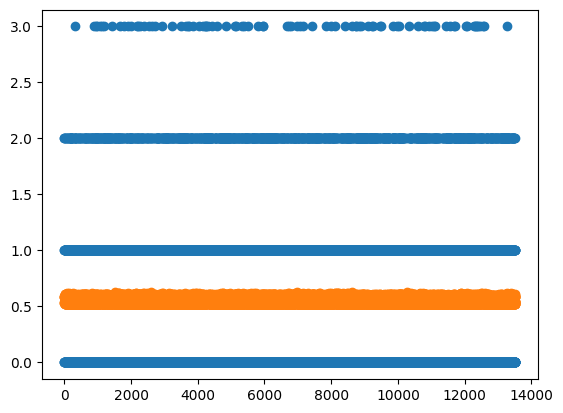

In [43]:
### NOT LOOKING SO GOOD RIGHT AWAY, NEED TO INCORPORATE THE OTHER METRICS AS WELL THEN EXTRACT HITS TO SEE ###
plt.scatter(np.arange(0, len(ytest)), ytest)
plt.scatter(np.arange(0, len(ypred)), ypred)

In [162]:
### NEURAL NETWORK ###
regr = neural_network.MLPRegressor(hidden_layer_sizes=(50,) ,random_state=100, max_iter=1000, learning_rate_init=0.02).fit(xtrain, ytrain)
ypred = regr.predict(xtest)

ValueError: Multioutput target data is not supported with label binarization

In [161]:
np.max(ypred[:,3])

0.7942336923110797

In [150]:
hits = []
for i in ypred[:,3]:
    if i >= 0.5:
        hits.append(1)
    else:
        hits.append(0)
print(np.sum(hits)/len(hits))

0.7181920359666024


In [151]:
hits = []
for i in ytest[:,3]:
    if i >= 0.5:
        hits.append(1)
    else:
        hits.append(0)
print(np.sum(hits)/len(hits))

0.46315028901734107


In [3]:
### ATTEMPT TO SEE IF TURNING HITS TO CATEGORICAL IS BETTER IDEA ###
out_values_cat = []
for i in range(len(out_values)):
    if out_values[i][3]>=1:
        out_values_cat.append(1)
    else:
        out_values_cat.append(0)
out_values_cat = np.array(out_values_cat).reshape(-1,1)
out_values_cat

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

(array([ 3525.,     0., 33354.,     0.,     0., 99610.,     0., 83044.,
            0.,  2747.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

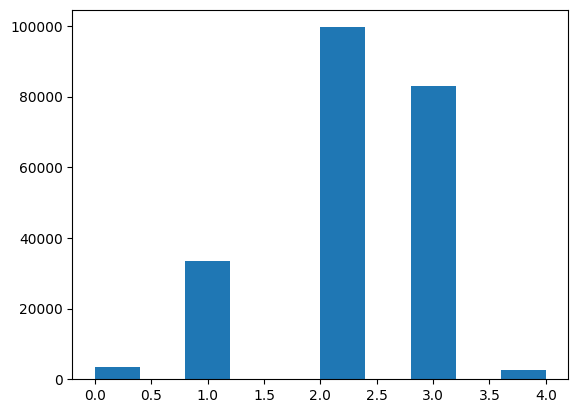

In [10]:
plt.hist(out_values[:,2])

In [48]:
### AVERAGE BATTING ###
x = out_values[:,3]/out_values[:,2]
np.mean(x[~np.isnan(x)])

### AVERAGE AT BATS ###
np.mean(out_values[:,2])

C:\Users\joshm\AppData\Local\Temp\ipykernel_20336\3241492268.py:2: RuntimeWarning: invalid value encountered in divide
  x = out_values[:,3]/out_values[:,2]


2.216546697858557

In [4]:
xtrain, xtest, ytrain, ytest = in_values[:160000], in_values[160000:], out_values_cat[:160000], out_values_cat[160000:]

In [13]:
### CREATE A RANDOM ARRAY OF 1s AND 0s TO SEE HOW THE MODEL COMPARES TO RANDOM GUESSES ###
ypred = np.round(np.random.rand(len(ytest)))
print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 0.4964354527938343
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.49975915221579964


In [28]:
np.sum(ytest)

28845

62280

In [30]:
### CREATE LIST OF NO HIT GUESSES TO SEE PERCENT CORRECT ###
ypred = np.array([1]*len(ytest))
print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 1.0
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.46315028901734107


In [5]:
### TESTING NEURAL NETWORK ###
regr = neural_network.MLPClassifier(hidden_layer_sizes=(35,) ,random_state=10, max_iter=300, early_stopping=True, solver='sgd').fit(xtrain, np.ravel(ytrain))
ypred = regr.predict(xtest)

In [6]:
print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent predicted to get hit: 0.2679993577392421
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.55


In [8]:
correct = []
for i in range(len(ypred)):
    if ypred[i]==1:
        if ypred[i]==ytest[i]:
            correct.append(1)
        else:
            correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

Percent of correct picks: 0.5245341800970583


In [13]:
### TEST TO SEE IDEAL LAYERS ###
perc_corr = []
for j in range(1, 1001):
    regr = neural_network.MLPClassifier(hidden_layer_sizes=(j,) ,random_state=10, max_iter=300, early_stopping=True, solver='sgd').fit(xtrain, np.ravel(ytrain))
    ypred = regr.predict(xtest)

    print('Layers:', j)
    print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
    print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
    correct = []
    for i in range(len(ypred)):
        if ypred[i]==ytest[i]:
            correct.append(1)
        else:
            correct.append(0)
    print('Percent of correct picks:', np.sum(correct)/len(correct))
    print(' ')
    perc_corr.append(np.sum(correct)/len(correct))

Layers: 1
Percent predicted to get hit: 0.28134232498394346
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5427906229929351
 
Layers: 2
Percent predicted to get hit: 0.2796563904945408
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.546660244059088
 
Layers: 3
Percent predicted to get hit: 0.3689627488760437
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5404945407835581
 
Layers: 4
Percent predicted to get hit: 0.33670520231213874
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.546034039820167
 
Layers: 5
Percent predicted to get hit: 0.24322414900449582
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.548699421965318
 
Layers: 6
Percent predicted to get hit: 0.34405908798972384
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5440751445086706
 
Layers: 7
Percent predicted to get hit: 0.344669235709698

c:\Users\joshm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Layers: 279
Percent predicted to get hit: 0.2537411689145793
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5490044958253051
 
Layers: 280
Percent predicted to get hit: 0.3090077071290944
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5471419396274888
 
Layers: 281
Percent predicted to get hit: 0.29425176621708415
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5480892742453436
 
Layers: 282
Percent predicted to get hit: 0.3065189466923571
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5484104046242775
 
Layers: 283
Percent predicted to get hit: 0.2874116891457932
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5491811175337187
 
Layers: 284
Percent predicted to get hit: 0.2706326268464997
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5492614001284521
 
Layers: 285
Percent predicted to get hit: 0.2

c:\Users\joshm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Layers: 386
Percent predicted to get hit: 0.2682080924855491
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5497270391779062
 


In [228]:
test = pd.DataFrame({'pred' : ypred, 'actual' : ytest[:,0], 'prob':regr.predict_proba(xtest)[:,1]})

In [232]:
test[(test['pred']==1)&(test['actual']==0)]

,pred,actual,prob
9,1,0,0.523662
10,1,0,0.506816
11,1,0,0.523662
20,1,0,0.523662
26,1,0,0.518154
...,...,...,...
62257,1,0,0.523662
62258,1,0,0.514355
62260,1,0,0.509715
62267,1,0,0.523662


In [268]:
### ATTEMPTING LOGISTIC REGRESSION ###
regr = linear_model.LogisticRegression(random_state=5, solver='newton-cholesky').fit(xtrain, ytrain)
ypred = regr.predict(xtest)

print('Percent predicted to get hit:',np.sum(ypred)/len(ypred))
print('Percent that actually got hit:', np.sum(ytest)/len(ytest))
correct = []
for i in range(len(ypred)):
    if ypred[i]==ytest[i]:
        correct.append(1)
    else:
        correct.append(0)
print('Percent of correct picks:', np.sum(correct)/len(correct))

c:\Users\joshm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Percent predicted to get hit: 0.2751766217084136
Percent that actually got hit: 0.46315028901734107
Percent of correct picks: 0.5484425176621709


In [3]:
query = """ 
    SELECT a.*
    FROM main_models.event_offense_stats as a
"""
df: pd.DataFrame = conn.sql(query).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game_id,event_key,team_id,player_id,baserunner,plate_appearances,at_bats,hits,singles,doubles,triples,home_runs,total_bases,strikeouts,walks,intentional_walks,hit_by_pitches,sacrifice_hits,sacrifice_flies,reached_on_errors,reached_on_interferences,inside_the_park_home_runs,ground_rule_doubles,infield_hits,on_base_opportunities,on_base_successes,runs_batted_in,grounded_into_double_plays,double_plays,triple_plays,batting_outs,balls_in_play,balls_batted,trajectory_fly_ball,trajectory_ground_ball,trajectory_line_drive,trajectory_pop_up,trajectory_unknown,trajectory_known,trajectory_broad_air_ball,trajectory_broad_ground_ball,trajectory_broad_unknown,trajectory_broad_known,bunts,batted_distance_plate,batted_distance_infield,batted_distance_outfield,batted_distance_unknown,batted_distance_known,fielded_by_battery,fielded_by_infielder,fielded_by_outfielder,fielded_by_known,fielded_by_unknown,batted_angle_left,batted_angle_right,batted_angle_middle,batted_angle_unknown,batted_angle_known,batted_location_plate,batted_location_right_infield,batted_location_middle_infield,batted_location_left_infield,batted_location_left_field,batted_location_center_field,batted_location_right_field,batted_location_unknown,batted_location_known,batted_balls_pulled,batted_balls_opposite_field,runs,times_reached_base,stolen_bases,caught_stealing,picked_off,picked_off_caught_stealing,outs_on_basepaths,unforced_outs_on_basepaths,outs_avoided_on_errors,advances_on_wild_pitches,advances_on_passed_balls,advances_on_balks,advances_on_unspecified_plays,advances_on_defensive_indifference,advances_on_errors,plate_appearances_while_on_base,balls_in_play_while_running,balls_in_play_while_on_base,batter_total_bases_while_running,batter_total_bases_while_on_base,extra_base_advance_attempts,bases_advanced,bases_advanced_on_balls_in_play,surplus_bases_advanced_on_balls_in_play,outs_on_extra_base_advance_attempts,pitches,swings,swings_with_contact,strikes,strikes_called,strikes_swinging,strikes_foul,strikes_foul_tip,strikes_in_play,strikes_unknown,balls,balls_called,balls_intentional,balls_automatic,unknown_pitches,pitchouts,pitcher_pickoff_attempts,catcher_pickoff_attempts,pitches_blocked_by_catcher,pitches_with_runners_going,passed_balls,wild_pitches,balks,left_on_base,left_on_base_with_two_outs,stolen_bases_second,stolen_bases_third,stolen_bases_home,caught_stealing_second,caught_stealing_third,caught_stealing_home,stolen_base_opportunities,stolen_base_opportunities_second,stolen_base_opportunities_third,stolen_base_opportunities_home,picked_off_first,picked_off_second,picked_off_third,times_force_on_runner,times_lead_runner,times_next_base_empty,extra_base_chances,extra_bases_taken
0,PIT200806110,539588729,WAS,dukee001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,4,1,1,2,1,0,0,0,1,0,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,PIT200806110,539588733,PIT,sancf001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,6,2,1,3,1,1,0,0,1,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,PIT200806110,539588735,PIT,doumr001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,3,2,2,2,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,PIT200806110,539588736,PIT,nadyx001,Batter,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,PIT200806120,539588929,WAS,boona001,Batter,1,1,1,1,0,0,0,1,0,0,0

In [6]:
np.max(pd.to_numeric(df['game_id'].str[3:7]))

2023